In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import torch

#if torch.has_mps:
#    device = torch.device('mps')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Datafolder = "../datasets/Reverberating_Damped_Random_Walk/oversampled_data/"
Modulesfolder = "../Modules/"

import sys
sys.path.append(Modulesfolder)


#JAX
import jax
import jax.numpy as jnp
# Probably should specify in the outer script, not the inner modules
from jax.config import config
config.update("jax_enable_x64", True)
#config.update("jax_debug_nans", True)

# for Matern kernel with Modified Bessel of the 2nd kind (tfp>=0.17.0-dev20220322)
import tensorflow_probability as tfp


#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)


fig = plt.figure()
#plt.plot()
mpl.style.use('default')
rcParams = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "lightgray",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.facecolor":'lightgray',
    "legend.edgecolor":'black',
    'axes.titlecolor': 'white'}

def set_style():
    global fig
    mpl.style.use('default')
    plt.rcParams.update(rcParams)
    fig.patch.set_alpha(0)

FS = 18 # fontsize


import warnings
warnings.simplefilter("ignore", UserWarning)

def to_date(time_array,offset_date='2000-01-01T00:00:00'):
    return np.array([pd.Timedelta(x,'days').round('d')+pd.Timestamp(offset_date) for x in time_array])

<Figure size 432x288 with 0 Axes>

In [2]:
import torch.multiprocessing as multiprocessing
multiprocessing.set_start_method('spawn')

In [3]:
from functools import partial
from scipy.interpolate import BSpline

@jax.jit
def split_six_keys(key):
  return jax.random.split(key,6)

class RDRW():

    def __init__(self,softening=1e-10,diagonal_softening=1e-8):

        self.softening = softening
        self.diagonal_softening = diagonal_softening


    def Power_spectrum(self,frequencies,Correlation_time,Reverberation_time,Variance = 1.,grid_step=1.):

        Normalisation = Variance**2 * (Correlation_time + Reverberation_time) /grid_step

        omega = 2* np.pi* frequencies

        Tau_factor = (1+omega**2 * Correlation_time**2)
        Rho_factor = (1+omega**2 * Reverberation_time**2)

        return Normalisation/Tau_factor/Rho_factor + self.diagonal_softening


    def RDRW_covariance(self,abs_time_difference, Correlation_time, Reverberation_time, Variance = 1.):

        Tau_ratio =  abs_time_difference / Correlation_time
        Rho_ratio = abs_time_difference / (Reverberation_time + self.softening)

        # caps of exponential factors to facilitate Cholesky decomposition
        #Tau_dependence = (Tau_ratio< -np.log(self.softening)) * jnp.exp(-Tau_ratio)
        #Rho_dependence = (Rho_ratio< -np.log(self.softening)) * jnp.exp(-Rho_ratio)

        Tau_dependence = jnp.exp(-Tau_ratio)
        Rho_dependence = jnp.exp(-Rho_ratio)

        Normalisation = 1. / (Correlation_time  - Reverberation_time)

        Time_dependence = Correlation_time * Tau_dependence - Reverberation_time * Rho_dependence

        return Variance*Normalisation * Time_dependence


    def conditional_distribution(self,desired_times,time_array, values_array,
            Correlation_time, Reverberation_time, Variance = 1., Mean = 0.):

        time_difference = desired_times[None,:] - time_array[:,None]

        Mutual_Correlations = self.RDRW_covariance(jnp.abs(time_difference),Correlation_time,Reverberation_time)

        Reference_Corr_matrix = self.RDRW_covariance(jnp.abs(time_array[None,:] - time_array[:,None]),Correlation_time,Reverberation_time)   + np.eye(len(time_array)) * self.diagonal_softening

        Reference_Cholesky = jax.scipy.linalg.cholesky(Reference_Corr_matrix, lower=True, overwrite_a=True)

        # Mean prediction
        alpha = jax.scipy.linalg.cho_solve((Reference_Cholesky, True), values_array)

        conditional_Mean = Mean + Mutual_Correlations.T @ alpha
        # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

        Mutual_Corr_matrix = jax.scipy.linalg.solve_triangular(Reference_Cholesky,Mutual_Correlations,lower=True,check_finite=False)

        desired_time_difference = desired_times[None,:] - desired_times[:,None]
        self_Correlation_matrix = self.RDRW_covariance(jnp.abs(desired_time_difference),Correlation_time,Reverberation_time)

        conditional_Covariance_matrix = Variance * (self_Correlation_matrix -  Mutual_Corr_matrix.T @ Mutual_Corr_matrix)

        return conditional_Mean,conditional_Covariance_matrix

class RDRW_simulator(RDRW):

    def __init__(self,duration = 10, Saturation_time=10, grid_step = 4, random_seed = 7, softening=1e-10,diagonal_softening=1e-6):
        super().__init__(softening,diagonal_softening)

        if Saturation_time is None:
          # so we have a frequency on duration time
          Saturation_time = duration

        # Saturation is 22 years because above it would be just a random walk np.power(10,3.2)/365*2*np.pi

        self.duration = duration
        self.Saturation_time = Saturation_time


        self.length = 2*round((duration+Saturation_time)*365/grid_step/2)
        self.grid_step = grid_step/365

        self.frequencies = np.fft.rfftfreq(self.length,grid_step/365)
        self.grid = np.arange(0,self.length)*grid_step/365
        self.Saturation_offset = 2*round((Saturation_time)*365/grid_step/2)

        self.rng_key = jax.random.PRNGKey(random_seed)

        self.cadence_logits, self.mean_cadence = self.cadence_params()
        # 1.1 to enure that it reaches 5 years
        self._time_size = round(duration*365 / self.mean_cadence)


        num_ref_points = 365
        step = 1 / num_ref_points
        self.query = np.linspace(step/2, 1 - step/2, num_ref_points,dtype=np.float32)
        self.full_query = np.repeat([self.query],self.duration,axis=0) + np.arange(self.duration)[:,None]

        self.simulator = self.get_simulator()


    def cadence_params(self,Day_amplitude = 0.7338, Poisson_scale = 4):
        # default values from high cadence observations in cosmograil dataset

        def cadence_pdf(x,A,const):
            return A*np.exp(-(x-1)/Poisson_scale)+const*(x==1)

        cadences = np.arange(1,25)
        probabilities = cadence_pdf(cadences,*[1.,Day_amplitude])
        probabilities/=probabilities.sum()

        logits = np.log(probabilities)

        math_expectation = (cadences*probabilities).sum()

        return logits,math_expectation

    def simulate_observation_times(self,key_cadence,key_night_times):

        exponential_cadences = jax.random.categorical(key_cadence, self.cadence_logits,
                                          shape=(self._time_size,))

        # to not overfit global shift
        start_point = exponential_cadences[0]
        # 1 day + possible poisson gaps
        cadences = 1+exponential_cadences[1:]

        # variation of obs time within night
        #night_times = jnp.clip(jax.random.laplace(key_night_times,shape=(self._time_size,)) * 0.055,-0.4,0.4)
        night_times = jax.random.uniform(key_night_times,shape=(self._time_size,),minval=-5/24,maxval=5/24)
        time_array = start_point + jnp.append(np.zeros(1),jnp.cumsum(cadences)) + night_times

        return time_array / 365

    def simulate_GP_on_regular_grid(self,Correlation_time,Reverberation_time,rng_key_magnitude):

        power = self.Power_spectrum(self.frequencies[1:],Correlation_time,Reverberation_time,grid_step=self.grid_step)

        noise = jax.random.normal(rng_key_magnitude,shape=(self.length,)).reshape(2,-1)
        phases = (noise*np.array([1.+0j,0.+1j])[:,None]).sum(axis=0)

        Fourier_image = jnp.append(np.zeros(1),jnp.sqrt(power)*phases)

        return jnp.fft.irfft(Fourier_image,norm='ortho')

    def simulate_GP_on_irregular_grid(self,Correlation_time,Reverberation_time,rng_key_regular_magnitude, rng_key_irregular_magnitude , rng_key_cadence, rng_key_night):

        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise

        return irregular_time_array,irregular_GP,irregular_Mean,irregular_Covariance_matrix,regular_GP

    def sample_gaps(self,key_width,key_shift,shape):
        duration_params = np.array([135,25])
        duration_bounds = np.array([80,220])
        duration_normalised_bounds = (duration_bounds - duration_params[0])/duration_params[1]
        widths = jax.random.truncated_normal(key_width,*duration_normalised_bounds,shape=shape)*duration_params[1]+duration_params[0]

        middle_shifts_scale = 12
        middle_shifts_bounds = np.array([-20,20])
        middle_shifts_normalised_bounds = middle_shifts_bounds/middle_shifts_scale
        middle_shifts = jax.random.truncated_normal(key_shift,*middle_shifts_normalised_bounds,shape=shape)*middle_shifts_scale

        return middle_shifts,widths

    def sample_nogaps_masks(self,time_array,grid_time,key_width,key_shift):

        gap_middle_shifts,gaps_widths = self.sample_gaps(key_width,key_shift,(self.duration+1,))

        # gap middle shift for selected year and
        gaps_starts = (gap_middle_shifts - gaps_widths/2)/365 + np.arange(self.duration+1)
        gaps_ends = (gap_middle_shifts + gaps_widths/2)/365 + np.arange(self.duration+1)

        nogaps_masks = (time_array[None,:] > gaps_ends[:-1,None]) & (time_array[None,:] < gaps_starts[1:,None])

        test_nogaps_masks = (grid_time[None,:] > gaps_ends[:-1,None]) & (grid_time[None,:] < gaps_starts[1:,None])

        return  nogaps_masks.sum(0).astype(bool),test_nogaps_masks.sum(0).astype(bool)

    def sample_irregular_time_mag_mask(self,Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift):


        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise


        nogaps_masks,test_nogaps_masks = self.sample_nogaps_masks(irregular_time_array,local_grid,rng_gap_key_width,rng_gap_key_shift)

        return irregular_time_array,irregular_GP,nogaps_masks,local_grid,local_regular_GP,test_nogaps_masks

    def get_simulator(self):

      @partial(jax.jit,backend='cpu')
      def simulator(Correlation_time,Reverberation_time,
                             rng_key):

        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift=
        #self.split_seven_keys(self.rng_key)
        rng_new_key, rng_key_regular_magnitude, rng_key_irregular_magnitude ,rng_key_cadence, rng_key_night, rng_gap_key_width,rng_gap_key_shift = jax.random.split(rng_key,7)

        return rng_new_key, self.sample_irregular_time_mag_mask(Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift)

      return simulator


    @partial(jax.jit,static_argnums=(0,), backend='cpu')
    def split_seven_keys(self,key):
        return jax.random.split(key,7)

    def sample_light_curve(self,Correlation_time,Reverberation_time):


        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift= self.split_seven_keys(self.rng_key)

        self.rng_key, (time_array,magnitude,nogaps_masks,test_time_array,test_magnitude,test_nogaps_masks) = self.simulator(Correlation_time/365,Reverberation_time/365,
                                                        self.rng_key)

        return np.array(time_array),np.array(magnitude),np.array(nogaps_masks),np.array(test_time_array),np.array(test_magnitude),np.array(test_nogaps_masks)

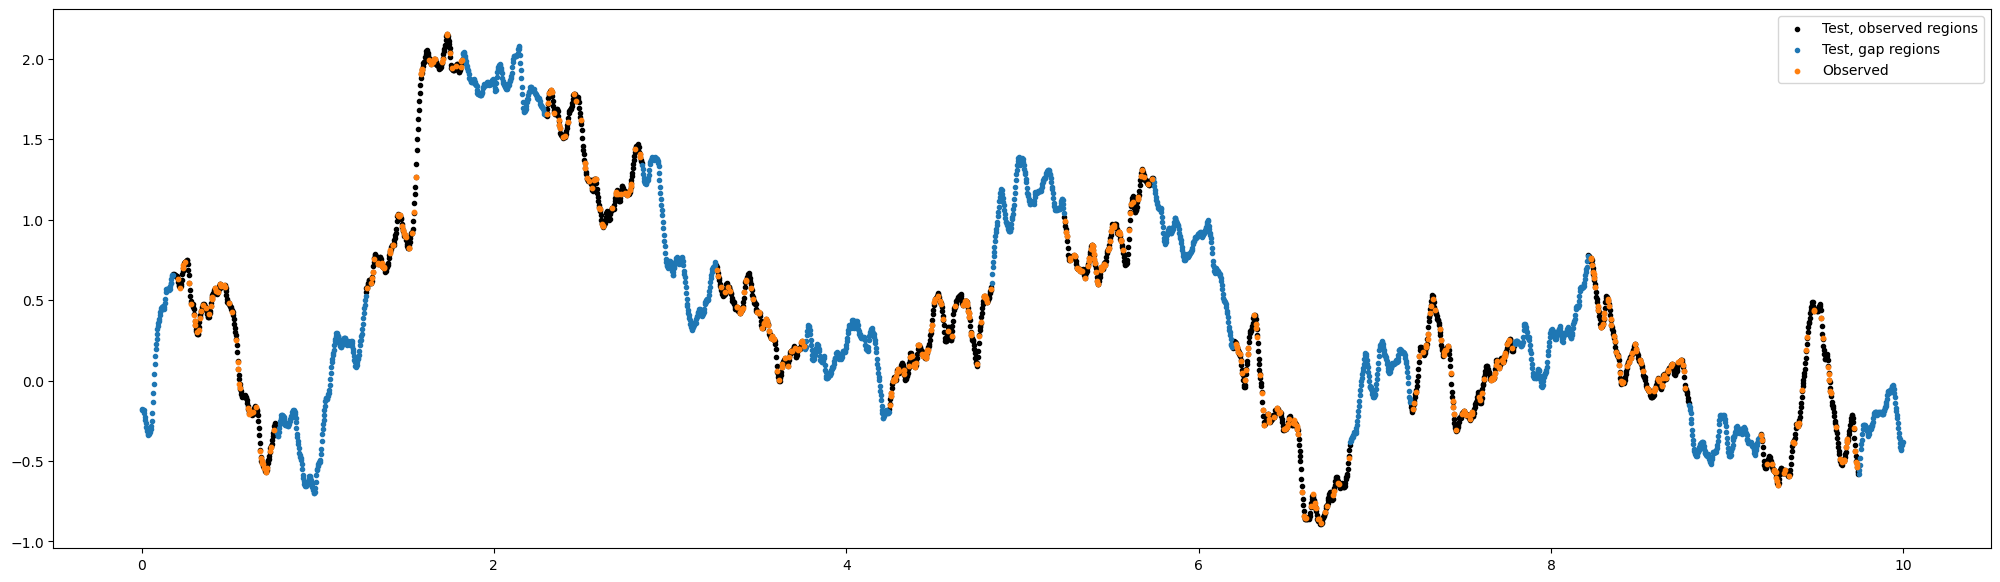

In [4]:
simulator = RDRW_simulator(grid_step=1)
tau = 540; rho=30/2/np.pi
time,magnitude,mask,test_time,test_magnitude,test_mask = simulator.sample_light_curve(tau,rho)
fig,ax = plt.subplots(figsize=(25,7))

plt.scatter(test_time[test_mask],test_magnitude[test_mask],color='k',marker='.',label='Test, observed regions')
plt.scatter(test_time[~test_mask],test_magnitude[~test_mask],color='C0',marker='.',label='Test, gap regions')
plt.scatter(time[mask],magnitude[mask],color='C1',label='Observed',s=10)

plt.legend()

In [5]:
sample_test_mask = (test_time>7) & (test_time<9)
sample_train_mask = (time>7) & (time<9)

time = time[sample_train_mask]
magnitude = magnitude[sample_train_mask]
mask = mask[sample_train_mask]

test_time = test_time[sample_test_mask]
test_magnitude = test_magnitude[sample_test_mask]
test_mask = test_mask[sample_test_mask]

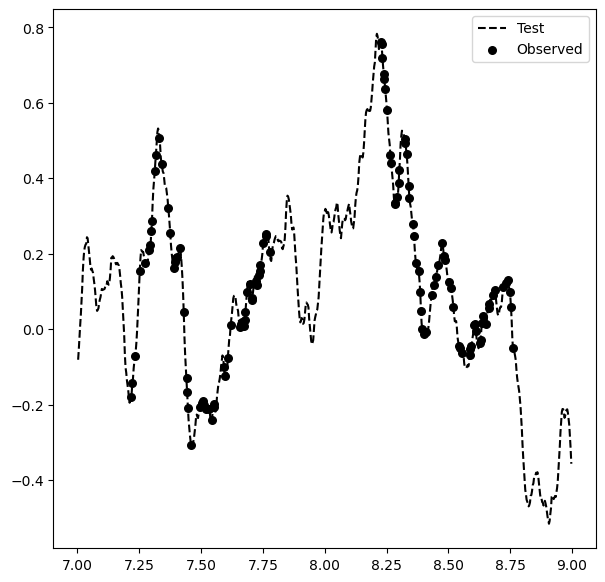

In [6]:
fig,ax = plt.subplots(figsize=(7,7))

plt.plot(test_time,test_magnitude,color='k',linestyle='--',label='Test',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='k',label='Observed',s=30)

plt.legend()

In [7]:
amp = .5*(magnitude[mask].max()-magnitude[mask].min())
magnitude /= amp
shift = magnitude[mask].min()+1
magnitude -=shift
test_magnitude /=amp
test_magnitude-=shift

In [8]:
time = time[mask]
magnitude = magnitude[mask]

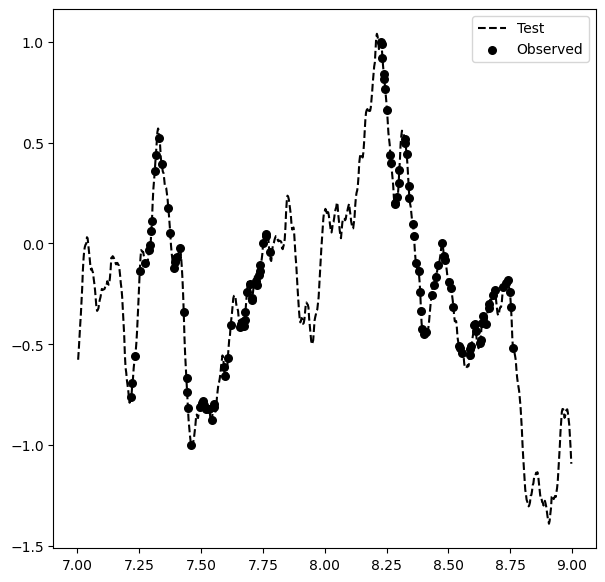

In [9]:
fig,ax = plt.subplots(figsize=(7,7))

plt.plot(test_time,test_magnitude,color='k',linestyle='--',label='Test',zorder=0)
plt.scatter(time,magnitude,color='k',label='Observed',s=30)

plt.legend()

In [10]:
def RDRW_kernel(time_difference, Variance, Correlation_time, Reverberation_time):
    """
    Autocorrelation function of Reverberating Damped Random Walk process. This is a difference of two Mater[nu=0.5] kernels.
    Formally it is subtraction of two laplacian kernels

    .. math::
        R_{FF}(\\Delta t) = \\sigma^2  \\frac{1}{t_{corr}- t_{rev}}
            \\left(t_{corr} e^{-\\frac{|\\Delta t|}{t_{corr}}} - t_{rev} e^{-\\frac{|\\Delta t|}{t_{rev}}}\\right),

    Parameters
    ----------
    time_difference: float [days]
        Difference in time between two points, for which correlation is estimated
    Variance: float
        Variance of a sampled point
    Correlation_time: float [days]
        Measure of global correlation between separated points. Defines global evolution.
    Reverberation_time: float [days]
        Measure of local correlation between separated points. Defines locall evolution.
        It is assumed that Reverberation_time<Correlation_time

    Returns
    -------
    R_{FF}(t_i - t_j) : float
        Correlation of radiation on time stamps t_i and t_j (stationary,isotropic)
    """


    Normalisation = 1. / (Correlation_time  - Reverberation_time)
    Time_dependence = Correlation_time * jnp.exp(-jnp.abs(time_difference) / (Correlation_time + eps)) - \
                      Reverberation_time * jnp.exp(-jnp.abs(time_difference) / (Reverberation_time + eps))


    return Variance*Normalisation*Time_dependence

@partial(jax.jit,backend='cpu')
def Cholesky_of_Covariance_matrix(time_array: jnp.ndarray, Normalised_errors: jnp.ndarray, Correlation_time: float,
                                  Reverberation_time: float):
    """
    Cholesky decomposition of Covariance matrix with unit variance

    Parameters
    ----------
    time_array: array (N,) [days]
        time stamps, on which the process should be sampled
    Normalised_errors: array (N,)
        Observation errors normalised by the Gaussian process' variance
    Correlation_time: float [days]
        Measure of global correlation between separated points. Defines global evolution.
    Reverberation_time: float [days]
        Measure of local correlation between separated points. Defines local evolution.
        It is assumed that Reverberation_time<Correlation_time

    Returns
    -------
        L: ndarray (N,N)
            Low triangular decomposition of the Covariance matrix
    """

    N = len(time_array)

    # Distance between time points for autocorrelation function
    x, y = jnp.meshgrid(time_array, time_array)
    time_difference = x - y

    get_Covariance = lambda time_difference: RDRW_kernel(time_difference, 1.,
                                                             Correlation_time, Reverberation_time)

    # Covariance kernel (unit variance in a time point)
    Covariance_matrix = get_Covariance(time_difference) + jnp.diag(Normalised_errors)
    # Now use Cholesky decomposition, but might change to sparce matrices jax.scipy.sparse.linalg
    Low_triangular_Covariance = jax.scipy.linalg.cholesky(Covariance_matrix, lower=True, overwrite_a=True)

    return Low_triangular_Covariance

@partial(jax.jit, static_argnums=(7, 8),backend='cpu')
def NegLogLikelihood(time_array: jnp.ndarray, values_array: jnp.ndarray, errors_array: jnp.ndarray,
                     Mean: float, Variance: float, Correlation_time: float,
                     Reverberation_time:float, Curve_type='RDRW', Normalised=True):
    """
    Estimates negative log-likelihood of hypothesis that a given time series (t,v) with errors e
    is a gaussian process with the parameters Mean,Variance,Correlation_time,Reverberation_time
    Parameters
    ----------
    time_array: array (N,) [days]
        time stamps, on which the process should be sampled
    values_array: array (N,) [days]
        values observed in the time points
    errors_array: array (N,) [days]
        uncertainties on those values expressed as gaussian standard deviation
    Mean: float
        Mean of the Gaussian process
    Variance: float
        Variance of the Gaussian process
    Correlation_time: float [days]
        Measure of global correlation between separated points. Defines global evolution.
    Reverberation_time: float [days]
        Measure of local correlation between separated points. Defines local evolution.
        It is assumed that Reverberation_time<Correlation_time
    Noise_std: float
        Std of noise atributed to the data
    Curve_type: 'RDRW' or 'DRW'
        Assumes either Reverberating Damped Random Walk (RDRW) kernel or DRW kernel (Matern[0.5])
    Normalised: bool
        True to include factor normalising total probability from the PDF to 1. False to consider 1/2*chi^2

    Returns
    -------
        -lnp(mu,sigma^2,t_corr,t_rev|t,x,e): float
    """

    N=len(time_array)


    # Use Cholesky decomposition to get lower triangle matrix describing covariance
    Low_triangular_Covariance = Cholesky_of_Covariance_matrix(time_array, (errors_array ** 2) / Variance,
                                                                   Correlation_time, Reverberation_time)

    # Mean estimation mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
    one = jnp.ones_like(values_array)

    # Euclidian Error estimation (self.y-mu*one).T @ inv_K @ (self.y-mu*one)
    Squared_Error = (values_array - Mean * one).T @ (jax.scipy.linalg.cho_solve((Low_triangular_Covariance, True), values_array - Mean * one))
    Chi_squared = Squared_Error / Variance / 2

    if not Normalised:
        return Chi_squared
    else:
        # log(det(K))
        LnDetCov = 2 * jnp.sum(jnp.log(jnp.diag(Low_triangular_Covariance)))
        # Normalisation of multivariate gaussian distribution
        Normalisation = 0.5 * N * (np.log(2*np.pi) + jnp.log(Variance)) + 0.5 * LnDetCov
        return Normalisation + Chi_squared

def Conditional_distribution(desired_times,time_array, values_array, errors_array, Mean, Variance,
            Correlation_time, Reverberation_time, Curve_type = 'RDRW',return_cov_matrix = False):

    one = jnp.ones_like(values_array)

    get_Covariance = lambda time_difference: RDRW_kernel(time_difference, 1.,
                                                             Correlation_time, Reverberation_time)

    time_difference = desired_times[None,:] - time_array[:,None]

    Covariances = get_Covariance(time_difference)

    Low_triangular_Covariance =  Cholesky_of_Covariance_matrix(time_array, (errors_array ** 2) / Variance,
                                                                   Correlation_time, Reverberation_time)

    # Mean prediction
    alpha = (jax.scipy.linalg.cho_solve((Low_triangular_Covariance, True), values_array - Mean * one))

    predicted_mean = Mean + Covariances.T @ alpha
    # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

    V = jax.scipy.linalg.solve_triangular(Low_triangular_Covariance,Covariances,lower=True,check_finite=False)

    err = (errors_array ** 2).mean()

    if return_cov_matrix:
        desired_time_difference = desired_times[None,:] - desired_times[:,None]
        predicted_corr_matrix = get_Covariance(desired_time_difference) - V.T @ V
        predicted_cov_matrix = Variance * predicted_corr_matrix  + np.eye(len(desired_times))*err
        return np.array(predicted_mean),np.array(predicted_cov_matrix)
    else:
        predicted_covariance =  get_Covariance(0.) - jnp.einsum("ij,ji->i", V.T, V)
        predicted_variance = Variance * predicted_covariance + err
        return np.array(predicted_mean),np.array(predicted_variance)

In [11]:
from typing import Union
eps= 1e-8


rho_bounds = np.array([0.55,10])
#log_tau_bounds = np.array([1.68,3.93])
#log_tau_params = np.array([2.73,0.3])
log_tau_bounds = np.array([1.05,2.76]) # from 10 days (third minimal in the paper, to 580 days, which is red noise for 10 years)

class Optimizer():

    def __init__(self,time_array,value_array,errors_array,Correlation_time = None,Reverberation_time = None,
                 normalisation: Union['day','year'] = 'day',report_learning = False,random_seed=7,Reverberation_time_guess = None):

        self.normalisation = normalisation

        if normalisation=='day':
            self.times = time_array / 365
        else:
            self.times = time_array

        self.values = value_array
        self.errors = errors_array

        self.Mean = None
        self.Variance = None

        rng = np.random.default_rng(random_seed)

        if (Correlation_time is None) and (Reverberation_time is None):
            self.optimized_task = 'All free'
            # default
            log_tau = scipy.stats.uniform(log_tau_bounds[0],log_tau_bounds[1]-log_tau_bounds[0]).rvs(size=1,random_state=rng)
            if Reverberation_time_guess is None:
              rho = scipy.stats.uniform(rho_bounds[0],rho_bounds[1]-rho_bounds[0]).rvs(size=1,random_state=rng)
            else:
              rho = Reverberation_time_guess
            Correlation_time = np.power(10,log_tau)
            Reverberation_time = rho

        elif (Correlation_time is not None) and (Reverberation_time is None):
            self.optimized_task = 'Fixed tau'
            if Reverberation_time_guess is None:
              rho = scipy.stats.uniform(rho_bounds[0],rho_bounds[1]-rho_bounds[0]).rvs(size=1,random_state=rng)
            else:
              rho = Reverberation_time_guess

        elif (Correlation_time is None) and (Reverberation_time is not None):

            self.optimized_task = 'Fixed rho'

            log_tau = scipy.stats.uniform(log_tau_bounds[0],log_tau_bounds[1]-log_tau_bounds[0]).rvs(size=1,random_state=rng)
            Correlation_time = np.power(10,log_tau)
        else:
            self.optimized_task = 'Fixed kernel'



        self.Correlation_time = Correlation_time /365
        self.Reverberation_time = Reverberation_time /365


        self.report_learning = report_learning


    def _args_to_labels(self,Arguments):
        Mean = Arguments[0]

        if self.optimized_task == 'All free':
            Correlation_time = np.power(10, Arguments[2])
            Reverberation_time = np.power(10, Arguments[3])
        elif self.optimized_task == 'Fixed tau':
            Correlation_time = self.Correlation_time
            Reverberation_time = np.power(10, Arguments[2])
        elif self.optimized_task == 'Fixed rho':
            Correlation_time = np.power(10, Arguments[2])
            Reverberation_time = self.Reverberation_time
        else:
            Correlation_time = self.Correlation_time
            Reverberation_time = self.Reverberation_time

        Variance = np.power(10, Arguments[1]) * (Correlation_time + Reverberation_time)

        Labels = [Mean, Variance, Correlation_time, Reverberation_time]


        return np.array(Labels)

    @partial(jax.jit, static_argnums=(0,),backend='cpu')
    def Full_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance = Arguments[:2]

        log_Correlation_time, log_Reverberation_time = Arguments[2:4]

        Correlation_time = jnp.power(10, log_Correlation_time)
        Reverberation_time = jnp.power(10, log_Reverberation_time)
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    @partial(jax.jit, static_argnums=(0,),backend='cpu')
    def Fixed_kernel_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance = Arguments[:2]

        Correlation_time = self.Correlation_time
        Reverberation_time = self.Reverberation_time
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    @partial(jax.jit, static_argnums=(0,),backend='cpu')
    def Fixed_Tau_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance,log_Reverberation_time = Arguments[:3]

        Correlation_time = self.Correlation_time
        Reverberation_time = jnp.power(10, log_Reverberation_time)
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    @partial(jax.jit, static_argnums=(0,),backend='cpu')
    def Fixed_Rho_Loss_RDRW(self, Arguments):

        Mean, Descaled_logVariance,log_Correlation_time = Arguments[:3]


        Correlation_time = jnp.power(10, log_Correlation_time)

        Reverberation_time = self.Reverberation_time
        Variance = jnp.power(10, Descaled_logVariance) * (Correlation_time + Reverberation_time)

        NLL = NegLogLikelihood(self.times, self.values, self.errors, Mean, Variance,
                                                 Correlation_time, Reverberation_time, Curve_type='RDRW',
                                                 Normalised=True)

        return NLL

    def compile_loss(self):

        if self.optimized_task == 'All free':
            return self.Full_Loss_RDRW
        elif self.optimized_task == 'Fixed tau':
            return self.Fixed_Tau_Loss_RDRW
        elif self.optimized_task == 'Fixed rho':
            return self.Fixed_Rho_Loss_RDRW
        else:
            return self.Fixed_kernel_Loss_RDRW

    def _prepare_for_optimization(self):

        Mean = self.values.mean()


        Correlation_time = self.Correlation_time
        Reverberation_time = self.Reverberation_time

        Descaled_Variance = self.values.var() / (Correlation_time + Reverberation_time)

        initial_RDRW_guess = np.array([Mean, jnp.log10(Descaled_Variance),
                                       jnp.log10(Correlation_time), jnp.log10(Reverberation_time)])

        Mean_bounds = [self.values.min(), self.values.max()]
        # log_Corr_time_bounds = [np.log10(np.diff(time_array).min()),np.log10(time_array.max())] # from https://iopscience.iop.org/article/10.1088/0004-637X/698/1/895/pdf
        log_Corr_time_bounds = [1. - np.log10(365) + eps, np.inf]
        log_Rev_time_bounds = [-np.inf, 1. - np.log10(365) - eps]

        lower_bound = np.array((Mean_bounds[0], -np.inf, log_Corr_time_bounds[0], log_Rev_time_bounds[0]))
        upper_bound = np.array((Mean_bounds[1], np.inf, log_Corr_time_bounds[1], log_Rev_time_bounds[1]))

        #bounds_RDRW = scipy.optimize.Bounds(lb=lower_bound,
        #                                    ub=upper_bound, keep_feasible=True)

        return initial_RDRW_guess,lower_bound,upper_bound

    def optimize(self,initial_guess = None, lower_bound = None ,upper_bound = None, **kwargs):

        suggestions = self._prepare_for_optimization()

        if initial_guess is None:
            initial_guess = suggestions[0]

        if lower_bound is None:
            lower_bound = suggestions[1]

        if upper_bound is None:
            upper_bound = suggestions[2]


        if self.optimized_task == 'All free':
            bounds = scipy.optimize.Bounds(lb=lower_bound,
                                            ub=upper_bound, keep_feasible=True)
        elif self.optimized_task == 'Fixed tau':
            initial_guess = initial_guess[[0,1,3]]
            bounds = scipy.optimize.Bounds(lb=lower_bound[[0,1,3]],
                                            ub=upper_bound[[0,1,3]], keep_feasible=True)
        elif self.optimized_task == 'Fixed rho':
            initial_guess = initial_guess[[0,1,2]]
            bounds = scipy.optimize.Bounds(lb=lower_bound[[0,1,2]],
                                            ub=upper_bound[[0,1,2]], keep_feasible=True)
        else:
            initial_guess = initial_guess[:-2]
            bounds = scipy.optimize.Bounds(lb=lower_bound[:-2],
                                            ub=upper_bound[:-2], keep_feasible=True)


        Loss_RDRW = self.compile_loss()
        grad = jax.grad(Loss_RDRW)
        hess = jax.jacfwd(jax.jacrev(Loss_RDRW))

        result, learning_curve = self._optimize(Loss_RDRW,grad,hess,initial_guess,bounds,**kwargs)

        labels = self._args_to_labels(result)
        labels[2:] = labels[2:] * 365

        return labels,learning_curve



    def _optimize(self,Loss, Gradient, Hessian, guess, bounds, method='TNC', options=None, use_hessian=False):

        if options is None:
            # options = {'disp':True,'maxiter':500}
            options = {}

        learning_curve = []

        global step
        step = 1

        def callbackF(Xi, *args):
            global step
            if self.report_learning:
                print(step , np.array(Xi))
            loss = Loss(Xi)

            learning_curve.append([*Xi, loss.item()])

            step += 1


        hess = lambda x: np.array(Hessian(x))
        if not use_hessian:
            hess = None

        def loss(x):
            l = Loss(x)
            if self.report_learning:
                print(x,l)
            return l

        grad = lambda x: np.array(Gradient(x))

        res = scipy.optimize.minimize(loss, guess, method=method, jac=grad, hess=hess,
                                      bounds=bounds, options=options)

        return res.x, learning_curve

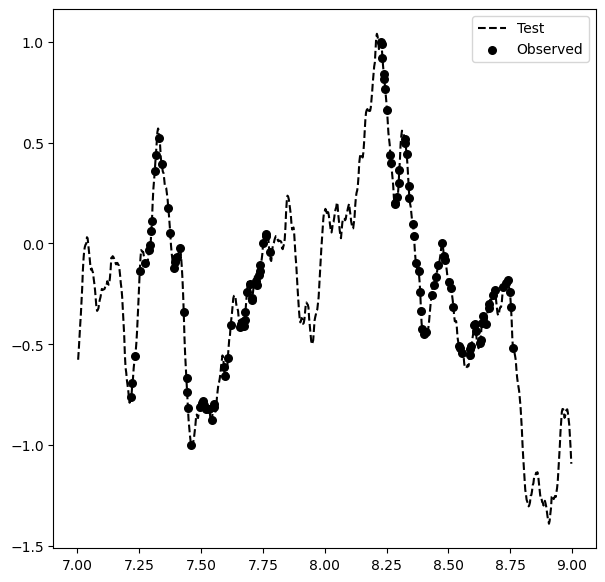

In [12]:
fig,ax = plt.subplots(figsize=(7,7))

plt.plot(test_time,test_magnitude,color='k',linestyle='--',label='Test',zorder=0)
plt.scatter(time,magnitude,color='k',label='Observed',s=30)

plt.legend()

In [13]:
optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(simulator.diagonal_softening)/amp,
                                  normalisation='year',Reverberation_time=0.,report_learning=False)
result_DRW,_ = optimizer.optimize()

mean_DRW, var_DRW = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(simulator.diagonal_softening)/amp,
                                             *result_DRW,return_cov_matrix=True)

In [14]:
optimizer = Optimizer(time, magnitude, np.ones_like(magnitude)*np.sqrt(simulator.diagonal_softening)/amp,
                                  normalisation='year',Correlation_time=tau,Reverberation_time=rho,report_learning=False)
result_RDRW,_ = optimizer.optimize()

mean_RDRW, var_RDRW = Conditional_distribution(test_time*365, time*365, magnitude, np.ones_like(magnitude)*np.sqrt(simulator.diagonal_softening)/amp,
                                             *result_RDRW,return_cov_matrix=True)

In [15]:
def compute_metrics(test_magnitude,test_mask,predicted_mean,predicted_var):

    test_data = test_magnitude[test_mask]

    pred_data = predicted_mean[test_mask]

    pred_uncertainty = np.sqrt(np.diag(predicted_var))[test_mask]

    chi2 = np.mean(((test_data - pred_data)/pred_uncertainty)**2)
    mae = np.mean(np.abs(test_data - pred_data))
    rmse = np.sqrt(np.mean((test_data - pred_data)**2))
    mad = np.median(np.abs(test_data - pred_data))

    return chi2,mae,rmse,mad

In [16]:
metrics_DRW = compute_metrics(test_magnitude,np.ones_like(test_magnitude,dtype=bool),mean_DRW,var_DRW)
metrics_RDRW = compute_metrics(test_magnitude,np.ones_like(test_magnitude,dtype=bool),mean_RDRW,var_RDRW)


In [17]:
metrics_DRW

(1.508077273656122,
 0.20382930086515821,
 0.33251444317177814,
 0.04259962282446039)

In [18]:
metrics_RDRW

(0.9452967608577392,
 0.18778729244689363,
 0.3130266857134546,
 0.029790421663896477)

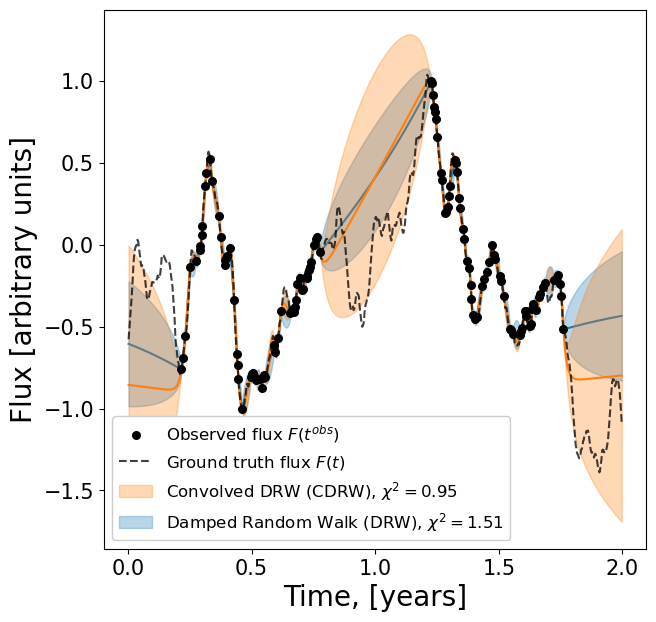

In [19]:
fig,ax = plt.subplots(figsize=(7,7))

plt.scatter(time-7,magnitude,color='k',label='Observed flux '+r'$F(t^{obs})$',s=30,zorder=2)
plt.plot(test_time-7,test_magnitude,color='k',linestyle='--',label='Ground truth flux '+r'$F(t)$',zorder=2,alpha=0.75)


plt.plot(test_time-7,mean_RDRW,zorder=1,color='C1')
plt.fill_between(test_time-7,mean_RDRW+np.sqrt(np.diag(var_RDRW)),mean_RDRW-np.sqrt(np.diag(var_RDRW)),alpha=0.3,zorder=1,
                 label='Convolved DRW (CDRW), '+r'$\chi^2 = 0.95$',color='C1')

plt.plot(test_time-7,mean_DRW,zorder=0,color='C0')
plt.fill_between(test_time-7,mean_DRW+np.sqrt(np.diag(var_DRW)),mean_DRW-np.sqrt(np.diag(var_DRW)),alpha=0.3,zorder=0,
                 label='Damped Random Walk (DRW), '+r'$\chi^2 = 1.51$',color='C0')


plt.xlabel('Time, [years]',fontsize=20)
plt.ylabel('Flux [arbitrary units]',fontsize=20)
plt.legend(loc='lower left',fontsize=12,framealpha=1)
fig.patch.set_alpha(0.)

ax.tick_params(axis='both', which='major', labelsize=15)

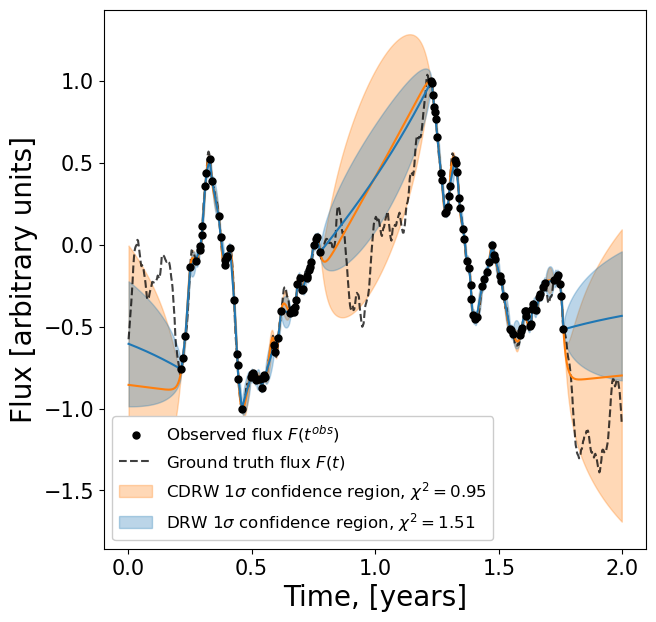

In [59]:
fig,ax = plt.subplots(figsize=(7,7))

plt.scatter(time-7,magnitude,color='k',label='Observed flux '+r'$F(t^{obs})$',s=25,zorder=3)
plt.plot(test_time-7,test_magnitude,color='k',linestyle='--',label='Ground truth flux '+r'$F(t)$',zorder=2,alpha=0.75)


plt.plot(test_time-7,mean_RDRW,zorder=2,color='C1')
plt.fill_between(test_time-7,mean_RDRW+np.sqrt(np.diag(var_RDRW)),mean_RDRW-np.sqrt(np.diag(var_RDRW)),alpha=0.3,zorder=1,
                 label='CDRW '+r'$1\sigma$'+' confidence region, '+r'$\chi^2 = 0.95$',color='C1')

plt.plot(test_time-7,mean_DRW,zorder=2,color='C0')
plt.fill_between(test_time-7,mean_DRW+np.sqrt(np.diag(var_DRW)),mean_DRW-np.sqrt(np.diag(var_DRW)),alpha=0.3,zorder=1,
                 label='DRW '+r'$1\sigma$'+' confidence region, '+r'$\chi^2 = 1.51$',color='C0')


plt.xlabel('Time, [years]',fontsize=20)
plt.ylabel('Flux [arbitrary units]',fontsize=20)
plt.legend(loc='lower left',fontsize=12,framealpha=1)
fig.patch.set_alpha(0.)

ax.tick_params(axis='both', which='major', labelsize=15)

In [62]:
ylim = ax.get_ylim()
xlim = ax.get_xlim()

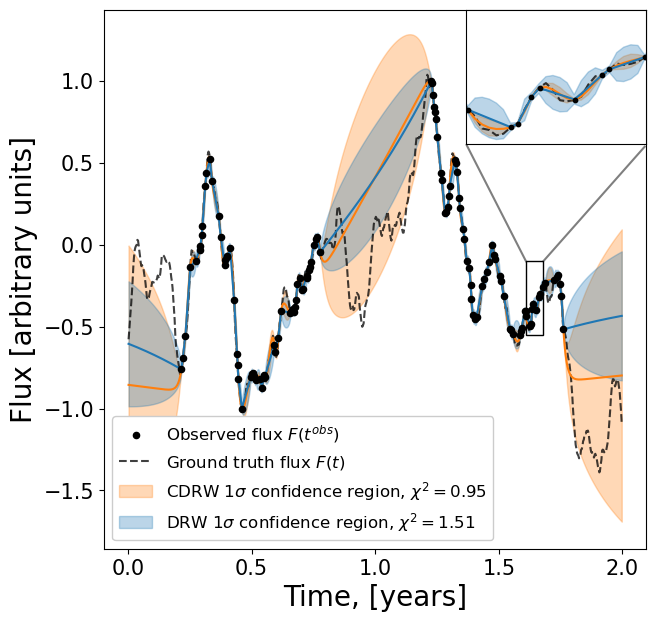

In [85]:
fig,ax = plt.subplots(figsize=(7,7))

def plot_all(ax,scatter_size=25):
    ax.scatter(time-7,magnitude,color='k',label='Observed flux '+r'$F(t^{obs})$',s=scatter_size,zorder=3)
    ax.plot(test_time-7,test_magnitude,color='k',linestyle='--',label='Ground truth flux '+r'$F(t)$',zorder=2,alpha=0.75)


    ax.plot(test_time-7,mean_RDRW,zorder=2,color='C1')
    ax.fill_between(test_time-7,mean_RDRW+np.sqrt(np.diag(var_RDRW)),mean_RDRW-np.sqrt(np.diag(var_RDRW)),alpha=0.3,zorder=1,
                 label='CDRW '+r'$1\sigma$'+' confidence region, '+r'$\chi^2 = 0.95$',color='C1')

    ax.plot(test_time-7,mean_DRW,zorder=2,color='C0')
    ax.fill_between(test_time-7,mean_DRW+np.sqrt(np.diag(var_DRW)),mean_DRW-np.sqrt(np.diag(var_DRW)),alpha=0.3,zorder=1,
                 label='DRW '+r'$1\sigma$'+' confidence region, '+r'$\chi^2 = 1.51$',color='C0')


plot_all(ax,scatter_size=20)


ax2 = ax.inset_axes([.666666, .75, .333333, .25],frame_on=True)

plot_all(ax2,scatter_size=10)
ax2.set_xticks([])
ax2.set_yticks([])

xlims = (1.61,1.68)
ylims = (-0.55,-0.1)
ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)
rect = mpl.patches.Rectangle((xlims[0],ylims[0]),xlims[1]-xlims[0],ylims[1]-ylims[0],alpha=1,edgecolor='k',facecolor='white',zorder=0)
ax.add_patch(rect)


ax.plot([1.61,1.37],[-0.1,0.61],color='k',alpha=0.5)
ax.plot([1.68,2.09],[-0.1,0.6],color='k',alpha=0.5)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

plt.xlabel('Time, [years]',fontsize=20)
plt.ylabel('Flux [arbitrary units]',fontsize=20)
plt.legend(loc='lower left',fontsize=12,framealpha=1)
fig.patch.set_alpha(0.)

ax.tick_params(axis='both', which='major', labelsize=15)